## Feature Extraction: SURF (Speeded-Up Robust Features) - used in K-nearest-neighbor and SVM

**Ressources**

- [A Comparison of SIFT, SURF, and ORB](https://medium.com/@shehan.a.perera/a-comparison-of-sift-surf-and-orb-333d64bcaaea)
- [Introduction to Orb](https://medium.com/data-breach/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)
- [ORB](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html)
- [Introduction to SURF](https://medium.com/data-breach/introduction-to-surf-speeded-up-robust-features-c7396d6e7c4e)
- [OpenCV Doku SURF](https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html)
- 

### Import resources and display image

In [ ]:
!pip3 install opencv-python

In [ ]:
!pip install scikit-image

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from skimage import io
import time

%matplotlib inline

from skimage import io
from skimage import color
from skimage.transform import resize
import math
from PIL import Image
from skimage import data, exposure
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

In [3]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import util
import surf_handling
import surf_hog_analysis 

In [ ]:
# Load the image
image1 = cv2.imread('data/train_images/0002cc93b.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(2, 1, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

### Detect keypoints and Create Descriptor

In [ ]:
surf = cv2.xfeatures2d.SURF_create(400)

train_keypoints, train_descriptor = surf.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = surf.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(2, 1, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

### Matching Keypoints

In [ ]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SURF descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In [ ]:
training_gray

In [3]:
img = cv2.imread('data/train_images/0002cc93b.jpg',0)
# Create SURF object. You can specify params here or later.
# Here I set Hessian Threshold to 400
surf = cv2.xfeatures2d.SURF_create(400)
# Find keypoints and descriptors directly
kp, des = surf.detectAndCompute(img,None)
print(len(kp), des.shape)


140 (140, 64)


In [4]:
# Check present Hessian threshold
print( surf.getHessianThreshold() )

400.0


In [5]:
# We set it to some 50000. Remember, it is just for representing in picture.
# In actual cases, it is better to have a value 300-500
surf.setHessianThreshold(300)
# Again compute keypoints and check its number.
kp, des = surf.detectAndCompute(img,None)

#np.set_printoptions(formatter={'float': '{: 0.10f}'.format})

print( len(kp), des.shape )
v = []
for idx, val in enumerate(des[0]):
    
    if idx%4 == 0 and idx != 0:
        formatted_v = [float("%.5f"%item) for item in v]
        #np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
        print(formatted_v)
        
        v = []
    v.append(val)
    
#print(des[0])

245 (245, 64)
[-0.00021, 0.00128, 0.0037, 0.00207]
[-0.00689, -0.01338, 0.02691, 0.03099]
[0.00325, -0.00416, 0.05055, 0.02059]
[0.00048, 0.00056, 0.00358, 0.00305]
[-0.01652, 8e-05, 0.02158, 0.02313]
[-0.28461, -0.09313, 0.34722, 0.13598]
[0.28264, -0.07892, 0.37419, 0.1615]
[-0.0065, 0.00614, 0.01835, 0.01669]
[0.00045, -0.00118, 0.01022, 0.02078]
[-0.19926, 0.16285, 0.27195, 0.26202]
[0.19633, 0.14247, 0.39089, 0.29573]
[-0.01046, 0.00299, 0.02326, 0.01178]
[-0.00173, 0.00274, 0.00209, 0.00347]
[0.00162, 0.00549, 0.02353, 0.01993]
[0.00089, 0.01162, 0.03228, 0.02582]


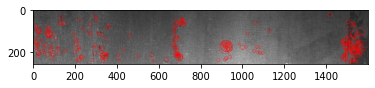

(<matplotlib.image.AxesImage at 0x12e00da30>, None)

In [6]:
img2 = cv2.drawKeypoints(img,kp,None,(255,0,0),4)
plt.imshow(img2),plt.show()

In [ ]:
# Find size of descriptor
print( surf.descriptorSize() )

In [ ]:
# That means flag, "extended" is False.
surf.getExtended()

In [ ]:
# So we make it to True to get 128-dim descriptors.
surf.setExtended(True)
kp, des = surf.detectAndCompute(img,None)
print( surf.descriptorSize() )

In [ ]:
print( des.shape )

In [ ]:
img3 = cv2.drawKeypoints(img,kp,None,(255,0,0),4)
plt.imshow(img3),plt.show()

In [ ]:
des[0]

---

### SURF-Attributes

In [7]:
print('Keypoint at:', kp[0].pt)
print('Keypoint diameter:', kp[0].size)
print('Direction of gradient:', kp[0].angle)

Keypoint at: (317.8110656738281, 178.74771118164062)
Keypoint diameter: 20.0
Direction of gradient: 1.72246253490448


In [8]:
len(kp)

245

---

### Apply SURF to all images

In [11]:
def add_keypoints_to_frame(df, surf_object):
    # prepare dictionary to gather data
    surf_images = {'keypoints': [],
                   'ImageId': [],
                   'NumberKP': []
                  }

    print('processing images...')
    start = time.time()

    for idx, image_id in enumerate(df.ImageId):
        surf_images['ImageId'].append(image_id)

        # `image` so far holds just the path to the image. Convert to image file
        image = io.imread("data/train_images/" + image_id)
        # Find keypoints and descriptors directly
        kp, des = surf_object.detectAndCompute(image, None)

        surf_images['keypoints'].append(kp)
        surf_images['NumberKP'].append(len(kp))
        if idx % 500 == 0 and idx != 0:
            print(f'image number {idx} processed...')

    end = time.time()
    print('processing done.')
    print('required time:', end - start)
    
    temp = pd.DataFrame.from_dict(surf_images)
    
    return temp

In [12]:
def build_keypoints_from_list(train_images_list, surf_object):
    # prepare dictionary to gather data
    surf_images = {'keypoints': [],
                   'ImageId': [],
                   'NumberKP': []
                  }

    print('processing images...')
    start = time.time()

    for idx, image in enumerate(train_images_list):
        surf_images['ImageId'].append(image.name)
    
        # `image` so far holds just the path to the image. Convert to image file
        image = io.imread("data/train_images/" + image.name)
        # Find keypoints and descriptors directly
        kp, des = surf.detectAndCompute(image, None)

        surf_images['keypoints'].append(kp)
        surf_images['NumberKP'].append(len(kp))
        if idx % 500 == 0 and idx != 0:
            print(f'image number {idx} processed...')

    end = time.time()
    print('processing done.')
    print('required time:', end - start)
    
    temp = pd.DataFrame.from_dict(surf_images)
    
    return temp

In [13]:
"""Processing time: ~3 minutes and 40 seconds.
"""

# get current working directory
cwd = pathlib.Path.cwd()
train_data_dir = cwd.joinpath('data', 'train_images')
train_images = list(train_data_dir.glob('*.jpg'))

# Create SURF object. You can specify params here or later.
# Here I set Hessian Threshold to 400
surf = cv2.xfeatures2d.SURF_create(400)

temp = build_keypoints_from_list(train_images, surf)

processing images...
image number 500 processed...
image number 1000 processed...
image number 1500 processed...
image number 2000 processed...
image number 2500 processed...
image number 3000 processed...
image number 3500 processed...
image number 4000 processed...
image number 4500 processed...
image number 5000 processed...
image number 5500 processed...
image number 6000 processed...
image number 6500 processed...
image number 7000 processed...
image number 7500 processed...
image number 8000 processed...
image number 8500 processed...
image number 9000 processed...
image number 9500 processed...
image number 10000 processed...
image number 10500 processed...
image number 11000 processed...
image number 11500 processed...
image number 12000 processed...
image number 12500 processed...
processing done.
required time: 229.44701719284058


In [1]:
"""Processing time: ~3 minutes and 40 seconds.
"""

# get current working directory
cwd = pathlib.Path.cwd()
train_data_dir = cwd.joinpath('data', 'train_images')
train_images = list(train_data_dir.glob('*.jpg'))

# Create SURF object. You can specify params here or later.
# Here I set Hessian Threshold to 400
surf = cv2.xfeatures2d.SURF_create(400)

# prepare dictionary to gather data
surf_images = {'keypoints': [],
               'ImageId': [],
               'NumberKP': []
              }

print('processing images...')
start = time.time()

for idx, image in enumerate(train_images):
    surf_images['ImageId'].append(image.name)
    
    # `image` so far holds just the path to the image. Convert to image file
    image = io.imread("data/train_images/"+image.name)
    # Find keypoints and descriptors directly
    kp, des = surf.detectAndCompute(image, None)
    
    surf_images['keypoints'].append(kp)
    surf_images['NumberKP'].append(len(kp))
    if idx % 500 == 0 and idx != 0:
        print(f'image number {idx} processed...')

end = time.time()
print('processing done.')
print('required time:', end - start)

NameError: name 'pathlib' is not defined

In [ ]:
temp = pd.DataFrame.from_dict(surf_images)
temp.head()

In [14]:
print(f"We have {temp.query('NumberKP < 50').count()[0]} keypoint vectors with less than 50 keypoints")

We have 2181 keypoint vectors with less than 50 keypoints


In [15]:
temp.sort_values(by='NumberKP', ascending=False)

,keypoints,ImageId,NumberKP
4794,"(<KeyPoint 0x28cf76240>, <KeyPoint 0x28cf76270...",f1bee5caa.jpg,4884
7482,"(<KeyPoint 0x2909701e0>, <KeyPoint 0x290970210...",72754d67c.jpg,4588
10717,"(<KeyPoint 0x294537540>, <KeyPoint 0x294537570...",efb8d2080.jpg,4577
7504,"(<KeyPoint 0x290a1b0c0>, <KeyPoint 0x290a1b0f0...",c097a0af1.jpg,4401
2101,"(<KeyPoint 0x288d61f00>, <KeyPoint 0x288d61f90...",31970c97b.jpg,4386
...,...,...,...
9196,(),caf49d870.jpg,0
12033,(),b1331b5aa.jpg,0
10622,(),f7f1db72c.jpg,0
10933,(),2b8b658d7.jpg,0


Adjust data frame and eliminate images that have more than 1 defect.

In [ ]:
util.isolate_single_defects(temp)

---

### Prepare data frame with (max) TOP50 Keypoints per image

In [ ]:
"""Expected run-time: ~ 35 minutes
"""
# apply functions to data frame
temp = surf_handling.add_keypoint_parameters(temp)

---

### Save data frame for further processing

In [ ]:
temp.to_csv('data/train_surf.csv', sep=',', index=False)

---

### Trials

In [ ]:
x = pd.DataFrame(columns = ['x'])
y = pd.DataFrame(columns = ['y'])
s = pd.DataFrame(columns = ['s'])

total_time = 0

start = time.time()
x.x = temp.keypoints.apply(lambda x: get_keypoint_x(x, 1))
end = time.time()
print('processing time x:', end-start)
total_time += end - start

start = time.time()
y.y = temp.keypoints.apply(lambda x: get_keypoint_y(x, 1))
end = time.time()
print('processing time y:', end-start)
total_time += end - start

start = time.time()
s.s = temp.keypoints.apply(lambda x: get_keypoint_size(x, 1))
end = time.time()
print('processing time s:', end-start)
total_time += end - start

start = time.time()
temp = pd.concat([temp, x, y, s], axis=1, ignore_index=False)

end = time.time()
print('processing time concat:', end-start)
total_time += end - start
print('total processing time was:', total_time)


## Use Surf Keypoints in a K-Nearest-Neighbor model and a SVM

In [95]:
surf = pd.read_csv('data/train_surf.csv')

In [96]:
util.isolate_single_defects(surf)

In [105]:
surf_complete = surf.merge(df[['ClassId','ImageId']], on = 'ImageId')
surf_complete = surf_complete.query('ClassId != 0')

In [107]:
# Drop irrelevant columns and split surf_complete into X and y
X_surf = surf_complete.drop(['ClassId','ImageId','keypoints'], axis =1)
y_surf = surf_complete['ClassId']

In [108]:
# Split  data
X_train, X_test, y_train, y_test = train_test_split(X_surf, y_surf, test_size=0.2, 
                                                    stratify=y_surf, random_state=42)

## K-nearest-neighbor

In [109]:
test_accuracy = []
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

0.717948717948718


[[ 38   5 110   1]
 [  7   2  30   0]
 [ 67  10 855  20]
 [  2   1  99   1]]


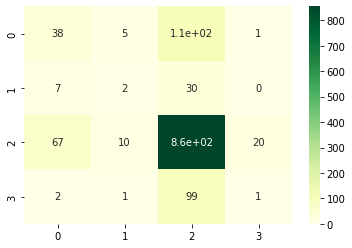

In [110]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [111]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.33      0.25      0.28       154
           2       0.11      0.05      0.07        39
           3       0.78      0.90      0.84       952
           4       0.05      0.01      0.02       103

    accuracy                           0.72      1248
   macro avg       0.32      0.30      0.30      1248
weighted avg       0.64      0.72      0.68      1248



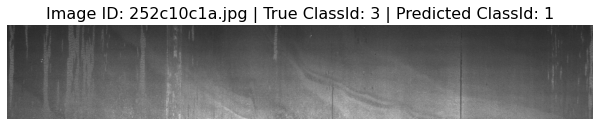

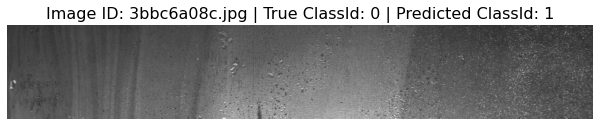

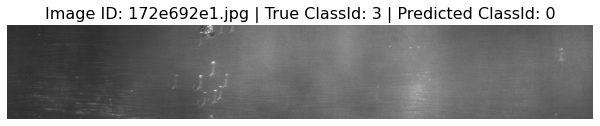

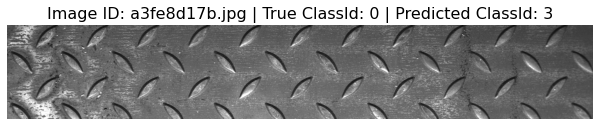

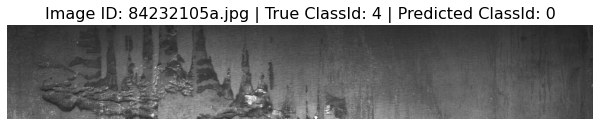

In [103]:
# print out several misclassified images
surf_hog_analysis.print_false_classifications(df, surf_complete, y_test, y_pred)

---

# SVM

In [ ]:
svm_model = svm.SVC(kernel='rbf', gamma=0.001, C = 100)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = svm_model.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
#Oversampling
ros = RandomOverSampler(random_state=42)
X_sros, y_sros = ros.fit_resample(X_train, y_train)

In [ ]:
test_accuracy = []
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sros)
X_test_scaled = scaler.transform(X_test)

svm_model.fit(X_train_scaled, y_sros)

y_pred = svm_model.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

In [ ]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'kernel': ['rbf'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 
               'C': [1, 10, 100, 1000]}]

grid = GridSearchCV(model, param_grid, verbose=True, n_jobs=-1)

result = grid.fit(X_train, y_train)

In [ ]:
# Print best parameters 
print('Best Parameters:', result.best_params_)

# Print best score
print('Best Score:', result.best_score_)

In [ ]:
surf_complete.groupby(['ClassId']).mean().NumberKP